In [1]:
import gudhi
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
import gudhi.representations
from itertools import combinations
import seaborn as sns
from gudhi.hera import wasserstein_distance
from gudhi.hera import bottleneck_distance
from collections import defaultdict
from scipy.interpolate import interp1d
from scipy.stats import ks_2samp
from scipy.spatial.distance import pdist

In [2]:
def nodesExtractorC(name): #extracts nodes and their corresponding information
    file_path = 'Networks/Network_Vessels_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'connectivity' field from the 'Data' structured array
    data_structure = matlab_data['nodesC2']
    # Reshape or ensure it's a proper 2D array (if required)
    nodes_data = data_structure.squeeze()
    # Create a DataFrame from the connectivity data
    nodes_df = pd.DataFrame(nodes_data, columns=['NodeID', 'X', 'Y', 'Z', 'Degree'])
    # Save the DataFrame to inspect it
    return nodes_df

def edgesExtractorC(name): #extracts segments to create a dataframe of from and to nodes
    file_path = 'Networks/Network_Vessels_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'connectivity' field from the 'Data' structured array
    data_structure = matlab_data['segments']
    # Reshape or ensure it's a proper 2D array (if required)
    edges_data = data_structure.squeeze()
    # Create a DataFrame from the connectivity data
    edge_df = pd.DataFrame(edges_data, columns=['ID', 'From', 'To'])
    # Save the DataFrame to inspect it
    return edge_df

def nodesExtractorH(name): #extracts nodes and their corresponding information
    file_path = 'Pruned/Pruned_Network_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'connectivity' field from the 'Data' structured array
    data_structure = matlab_data['nodesC3']
    # Reshape or ensure it's a proper 2D array (if required)
    nodes_data = data_structure.squeeze()
    # Create a DataFrame from the connectivity data
    nodes_df = pd.DataFrame(nodes_data, columns=['NodeID', 'X', 'Y', 'Z', 'Degree'])
    # Save the DataFrame to inspect it
    return nodes_df

def edgesExtractorH(name): #extracts segments to create a dataframe of from and to nodes
    file_path = 'Pruned/Pruned_Network_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'connectivity' field from the 'Data' structured array
    data_structure = matlab_data['segments']
    # Reshape or ensure it's a proper 2D array (if required)
    edges_data = data_structure.squeeze()
    # Create a DataFrame from the connectivity data
    edge_df = pd.DataFrame(edges_data, columns=['ID', 'From', 'To'])
    # Save the DataFrame to inspect it
    return edge_df

def inputForGUDHI(name, direction, height): #height is 1 for x, 2 for y, 3 for z
    #this creates the correct data format for GUDHI to run 0-D persistence
    edge_df = edgesExtractorC(name)
    node_df = nodesExtractorC(name)
    edges = list(edge_df.iloc[:,[1,2]].itertuples(index=False,name=None))
    if direction=='pos':
        node_heights = dict(zip(node_df.iloc[:,0],node_df.iloc[:,height]))
    elif direction=='neg':
        node_heights = dict(zip(node_df.iloc[:,0],437-node_df.iloc[:,height]))#CHANGE 437 IF NODES/EDGES ARE NO LONGER IN VOXELS
    return edges, node_heights

def nodesToArrayC(name):
    nodes_df = nodesExtractorC(name)
    nodes_loc = nodes_df.loc[:,['X','Y','Z']]/1000
    loc_array = nodes_loc.to_numpy()
    return loc_array

def nodesToArrayH(name):
    nodes_df = nodesExtractorH(name)
    nodes_loc = nodes_df.loc[:,['X','Y','Z']]/1000
    loc_array = nodes_loc.to_numpy()
    return loc_array

def compute_pointcloud_diameter(points):
    # Returns the maximum Euclidean distance (diameter)
    dists = pdist(points)
    return np.max(dists)

def compute_persistence(points):
    """
    Compute persistence diagram and an adaptive cutoff value.
    Excludes infinite values in H1 and H2.
    """
    # --- Build alpha complex ---
    alpha_complex = gudhi.AlphaComplex(points=points)
    simplex_tree = alpha_complex.create_simplex_tree()
    simplex_tree.compute_persistence()

    # --- Collect persistence pairs ---
    persistence_pairs = simplex_tree.persistence()

    # DIAGNOSTIC: Check for infinite bars
    for dim, (birth, death) in persistence_pairs:
        if np.isinf(death):
            print(f"WARNING: Infinite bar in H{dim}: birth={birth}, death=∞")

    # --- Filter infinite bars for H1/H2 ---
    diag = []
    for dim, (birth, death) in persistence_pairs:
        # Keep all finite bars and infinite H0 (main component)
        """if dim in [1, 2] and np.isinf(death):
            continue"""
        diag.append((dim, (birth, death)))

    # --- Compute filtration-based cutoff (for consistency) ---
    filtration_values = np.array([f for _, f in simplex_tree.get_filtration()])
    if len(filtration_values) > 0:
        filtration_cutoff = np.percentile(filtration_values, 99)
    else:
        filtration_cutoff = None

    # --- Compute adaptive cutoff from finite H1/H2 deaths ---
    finite_deaths = np.array([
        death for dim, (birth, death) in diag
        if dim in [1, 2] and np.isfinite(death)
    ])
    if len(finite_deaths) > 0:
        adaptive_cutoff = np.percentile(finite_deaths, 95)
    else:
        adaptive_cutoff = filtration_cutoff  # fallback

    return diag, adaptive_cutoff


def average_curves(curve_dicts, resolution=10000):
    """
    Generic averaging function for any type of curve dicts (Betti, lifespan, etc.)
    curve_dicts: list of dicts {dim: (grid, curve)}
    Returns: dict {dim: (common_grid, avg_curve)}
    """
    average = {}

    dims = set().union(*(d.keys() for d in curve_dicts))

    for dim in dims:
        all_grids, all_curves = [], []
        for cdict in curve_dicts:
            if dim not in cdict:
                continue
            grid, curve = cdict[dim]
            if len(grid) == 0:
                continue
            all_grids.append(grid)
            all_curves.append(curve)

        if not all_grids:
            average[dim] = (np.array([]), np.zeros(resolution))
            continue

        global_min = min(g[0] for g in all_grids)
        global_max = max(g[-1] for g in all_grids)
        common_grid = np.linspace(global_min, global_max, resolution)

        interpolated = []
        for grid, curve in zip(all_grids, all_curves):
            f = interp1d(grid, curve, bounds_error=False, fill_value=0)
            interpolated.append(f(common_grid))

        avg_curve = np.mean(interpolated, axis=0)
        average[dim] = (common_grid, avg_curve)

    return average

In [3]:
pressure = '1'

datasets = {
    'm1053007': nodesToArrayH('m1p'+pressure+'_053007'),
    'm2053007': nodesToArrayH('m2p'+pressure+'_053007'),
    'm1053107': nodesToArrayH('m1p'+pressure+'_053107'),
    'm2053107': nodesToArrayH('m2p'+pressure+'_053107'),
    'm1060107': nodesToArrayH('m1p'+pressure+'_060107'),
    'm1060407': nodesToArrayC('m1p'+pressure+'_060407'),
    'm2060407': nodesToArrayC('m2p'+pressure+'_060407'),
    'm3060407': nodesToArrayC('m3p'+pressure+'_060407'),
    'm1060507': nodesToArrayC('m1p'+pressure+'_060507'),
    'm2060507': nodesToArrayC('m2p'+pressure+'_060507'),
    'm3060507': nodesToArrayC('m3p'+pressure+'_060507'),
    'm2060607': nodesToArrayC('m2p'+pressure+'_060607'),
    'm3060607': nodesToArrayC('m3p'+pressure+'_060607'),
}

# Example usage across all datasets
persistence_results = {
    name: compute_persistence(points)
    for name, points in datasets.items()
}

# Separate results
persistence_diagrams = {name: res[0] for name, res in persistence_results.items()}
cutoffs = {name: res[1] for name, res in persistence_results.items()}

# Betti Curves

In [4]:
def compute_betti_curve(diag, max_dim=2, resolution=100000, cutoff=None):
    betti_curves = {}
    
    # Determine global filtration range across ALL dimensions
    all_values = []
    for dim, (birth, death) in diag:
        all_values.append(birth)
        if np.isfinite(death):
            all_values.append(death)
    
    global_min = np.min(all_values) if all_values else 0
    global_max = np.max(all_values) if all_values else 1
    
    if cutoff is not None:
        global_max = cutoff
    
    for dim in range(max_dim + 1):
        diag_dim = np.array([pt[1] for pt in diag if pt[0] == dim])
        
        if len(diag_dim) == 0:
            betti_curves[dim] = (np.zeros(resolution), np.zeros(resolution))
            continue
        
        # Use GLOBAL range, not per-dimension range
        grid = np.linspace(global_min, global_max, resolution)
        curve = np.zeros_like(grid)
        
        for birth, death in diag_dim:
            if np.isinf(death):
                # Infinite bar: alive from birth onward
                curve += (grid >= birth)
            else:
                # Finite bar: alive in [birth, death]
                curve += (grid >= birth) & (grid <= death)
        
        betti_curves[dim] = (grid, curve)
    
    return betti_curves

def plot_multiple_betti_curves(curves_dicts, labels, dimension, title='Betti Curves Comparison'):
    """
    curves_dicts: list of betti_curve dicts {dim: (grid, curve)}
    labels: list of labels for each curve
    dimension: the Betti number (int) to plot
    """
    plt.figure(figsize=(10, 6))

    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'cyan', 'magenta']
    linestyles = ['-', '--', '-.', ':']

    for idx, (curve_dict, label) in enumerate(zip(curves_dicts, labels)):
        if dimension in curve_dict:
            grid, curve = curve_dict[dimension]
            if len(grid) > 0:
                color = colors[idx % len(colors)]
                linestyle = linestyles[idx % len(linestyles)]
                plt.plot(grid, curve, color=color, linestyle=linestyle, label=f'{label} (Betti-{dimension})')
        else:
            print(f"Warning: {label} does not contain Betti-{dimension}")

    plt.title(f'{title} (Betti-{dimension})', fontsize=28)
    plt.xlabel('Filtration Value', fontsize=20)
    plt.ylabel(f'Betti-{dimension}', fontsize=20)
    #plt.xlim([0,5])
    plt.legend(fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(False)
    plt.tight_layout()
    plt.show()



In [35]:
betti_curves = {}
for name, diag in persistence_diagrams.items():
    points = datasets[name]
    cutoff_alpha2 = compute_pointcloud_diameter(points) ** 2
    betti_curves[name] = compute_betti_curve(diag, cutoff=15)

In [6]:
"""last_nonzero = {}

for name, dims in betti_curves.items():
    last_nonzero[name] = {}
    for dim, (alphas, betti_vals) in dims.items():
        # Find indices where Betti != 0
        nz = np.where(betti_vals != 0)[0]
        if len(nz) == 0:
            last_nonzero[name][dim] = {
                "alpha": None,
                "betti": 0
            }
        else:
            idx = nz[-1]
            last_nonzero[name][dim] = {
                "alpha": alphas[idx],      # location in the filtration
                "betti": betti_vals[idx]   # last nonzero Betti value
            }

last_nonzero"""

'last_nonzero = {}\n\nfor name, dims in betti_curves.items():\n    last_nonzero[name] = {}\n    for dim, (alphas, betti_vals) in dims.items():\n        # Find indices where Betti != 0\n        nz = np.where(betti_vals != 0)[0]\n        if len(nz) == 0:\n            last_nonzero[name][dim] = {\n                "alpha": None,\n                "betti": 0\n            }\n        else:\n            idx = nz[-1]\n            last_nonzero[name][dim] = {\n                "alpha": alphas[idx],      # location in the filtration\n                "betti": betti_vals[idx]   # last nonzero Betti value\n            }\n\nlast_nonzero'

In [7]:
"""last_not_one_dim0 = {}

for name, dims in betti_curves.items():
    alphas, betti0 = dims[0]  # dimension 0 only
    
    # find indices where Betti-0 != 1
    nz = np.where(betti0 != 1)[0]

    if len(nz) == 0:
        last_not_one_dim0[name] = {
            "alpha": None,
            "betti": None
        }
    else:
        idx = nz[-1]
        last_not_one_dim0[name] = {
            "alpha": alphas[idx],
            "betti": betti0[idx]
        }

last_not_one_dim0
"""

'last_not_one_dim0 = {}\n\nfor name, dims in betti_curves.items():\n    alphas, betti0 = dims[0]  # dimension 0 only\n    \n    # find indices where Betti-0 != 1\n    nz = np.where(betti0 != 1)[0]\n\n    if len(nz) == 0:\n        last_not_one_dim0[name] = {\n            "alpha": None,\n            "betti": None\n        }\n    else:\n        idx = nz[-1]\n        last_not_one_dim0[name] = {\n            "alpha": alphas[idx],\n            "betti": betti0[idx]\n        }\n\nlast_not_one_dim0\n'

In [8]:
"""for name, diag in persistence_diagrams.items():
    points = datasets[name]
    print(compute_pointcloud_diameter(points))"""

'for name, diag in persistence_diagrams.items():\n    points = datasets[name]\n    print(compute_pointcloud_diameter(points))'

In [ ]:
"""trimmed_betti_curves = {}

alpha_cut = 15

for name, dims in betti_curves.items():
    trimmed_betti_curves[name] = {}

    for dim, (alphas, betti_vals) in dims.items():

        # Find where alphas <= 20
        idx = np.where(alphas <= alpha_cut)[0]

        if len(idx) == 0:
            # no alphas ≤ 20
            trimmed_betti_curves[name][dim] = (np.array([]), np.array([]))
        else:
            last = idx[-1]
            trimmed_betti_curves[name][dim] = (
                alphas[:last+1],
                betti_vals[:last+1]
            )"""

In [36]:
# Get keys in insertion order
keys = list(betti_curves.keys())

hyper_curves = [betti_curves[k] for k in keys[:5]]
control_curves  = [betti_curves[k] for k in keys[-8:]]

average_control = average_curves(control_curves)
average_hyper = average_curves(hyper_curves)

In [ ]:
"""# Get keys in insertion order
keys = list(trimmed_betti_curves.keys())

hyper_curves = [trimmed_betti_curves[k] for k in keys[:5]]
control_curves  = [trimmed_betti_curves[k] for k in keys[-8:]]

average_control = average_curves(control_curves)
average_hyper = average_curves(hyper_curves)"""

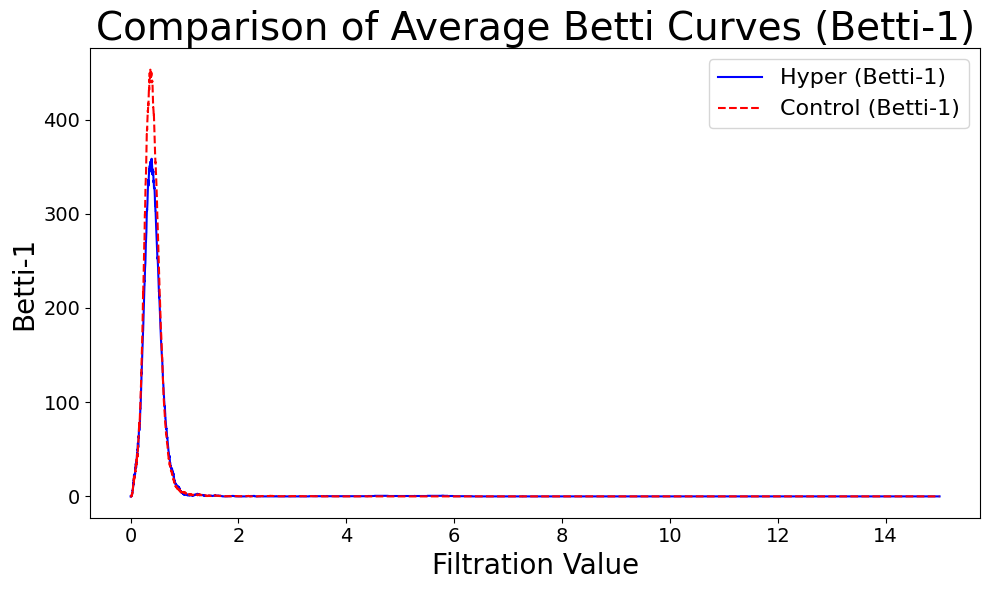

In [37]:
plot_multiple_betti_curves(
    [average_hyper, average_control],
    labels=["Hyper", "Control"], dimension = 1,
    title="Comparison of Average Betti Curves"
)

In [42]:
def plot_named_betti_curves(betti_curves_dict, dimension=0, title='Betti Curves (Dimension 1)'):
    """
    betti_curves_dict: dict of {name: betti_curve_dict}
    Each betti_curve_dict is like {dim: (grid, curve)}
    """
    if len(betti_curves_dict) != 13:
        raise ValueError("Expected 13 Betti curve dicts.")

    plt.figure(figsize=(10, 6))

    for idx, (name, curve_dict) in enumerate(betti_curves_dict.items()):
        if dimension not in curve_dict:
            continue

        grid, curve = curve_dict[dimension]

        if len(grid) == 0:
            continue

        color = 'blue' if idx < 5 else 'red'
        label = name 

        plt.plot(grid, curve, color=color, alpha=0.6, linewidth=1.5, label=label)

    plt.title(title)
    plt.xlabel('Filtration Value')
    plt.ylabel(f'Betti-{dimension}')
    plt.grid(True)

    if plt.gca().get_legend_handles_labels()[0]:
        plt.legend()

    plt.tight_layout()
    plt.show()


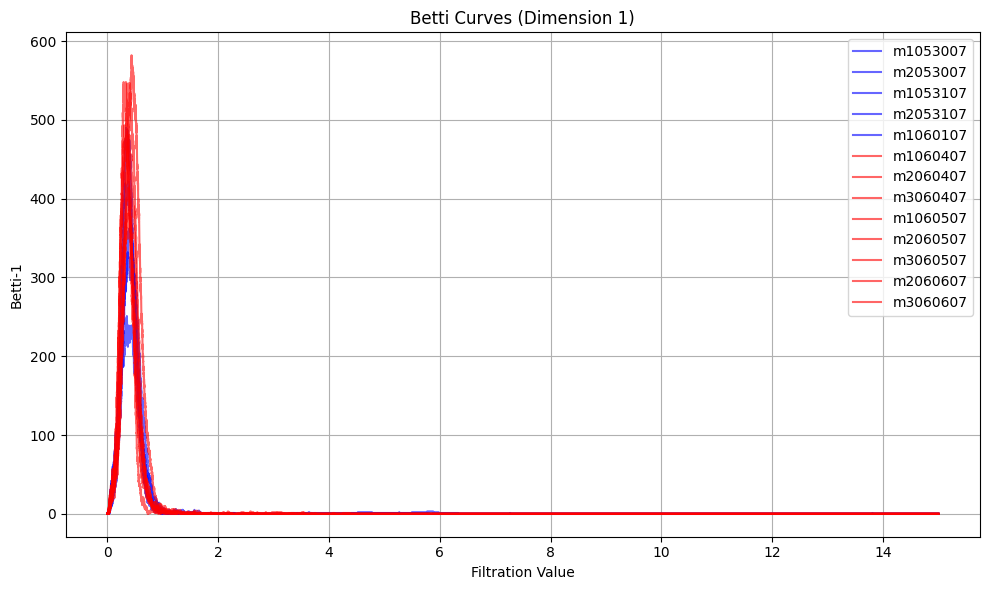

In [44]:
plot_named_betti_curves(betti_curves, dimension= 1, title='Betti Curves (Dimension 1)')

# Norm Curve

In [13]:
def normalize_betti_curves(betti_curves, method='max'):
    """
    Normalize Betti curves using specified method.
    method: 'area' | 'max' | 'sum'
    """
    normalized = {}

    for dim, (grid, curve) in betti_curves.items():
        if len(grid) == 0:
            normalized[dim] = (grid, curve)
            continue

        if method == 'area':
            norm = np.trapezoid(curve, grid)
        elif method == 'max':
            norm = np.max(curve)
        elif method == 'sum':
            norm = np.sum(curve)
        else:
            raise ValueError(f"Unknown normalization method: {method}")

        if norm > 0:
            normalized_curve = curve / norm
        else:
            normalized_curve = curve

        normalized[dim] = (grid, normalized_curve)

    return normalized

def plot_multiple_norm_betti_curves(curves_dicts, labels, dimension, title='Norm Betti Curves Comparison'):
    """
    curves_dicts: list of betti_curve dicts {dim: (grid, curve)}
    labels: list of labels for each curve
    dimension: the Betti number (int) to plot
    """
    plt.figure(figsize=(10, 6))

    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'cyan', 'magenta']
    linestyles = ['-', '--', '-.', ':']

    for idx, (curve_dict, label) in enumerate(zip(curves_dicts, labels)):
        if dimension in curve_dict:
            grid, curve = curve_dict[dimension]
            if len(grid) > 0:
                color = colors[idx % len(colors)]
                linestyle = linestyles[idx % len(linestyles)]
                plt.plot(grid, curve, color=color, linestyle=linestyle, label=f'{label} (Betti-{dimension})')
        else:
            print(f"Warning: {label} does not contain Betti-{dimension}")

    plt.title(f'{title} (Betti-{dimension})', fontsize=28)
    plt.xlabel('Filtration Value', fontsize=20)
    plt.ylabel(f'Betti-{dimension}', fontsize=20)
    plt.legend(fontsize=16)
    plt.xticks(fontsize=14)
    plt.xlin([0,50])
    plt.yticks(fontsize=14)
    plt.grid(False)
    plt.tight_layout()
    plt.show()


In [38]:
norm_betti_curves = {
    name: normalize_betti_curves(diag,method='area')
    for name, diag in betti_curves.items()
}

# Get keys in insertion order
keys = list(betti_curves.keys())

hyper_curves_norm = [norm_betti_curves[k] for k in keys[:5]]
control_curves_norm  = [norm_betti_curves[k] for k in keys[-8:]]

average_control_norm = average_curves(control_curves_norm)
average_hyper_norm = average_curves(hyper_curves_norm)

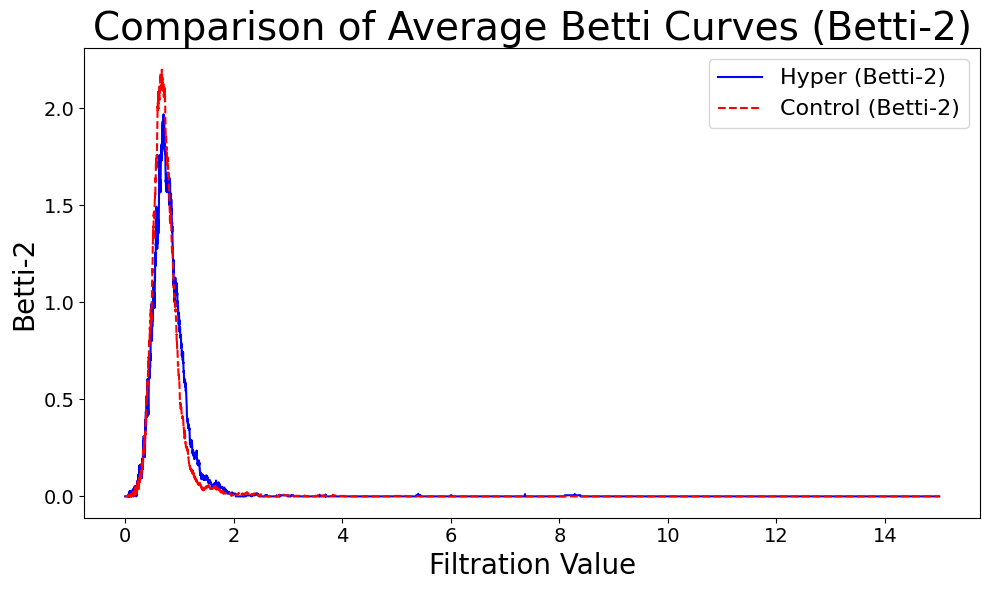

In [41]:
plot_multiple_betti_curves(
    [average_hyper_norm, average_control_norm],
    labels=["Hyper", "Control"], dimension = 2,
    title="Comparison of Average Betti Curves"
)

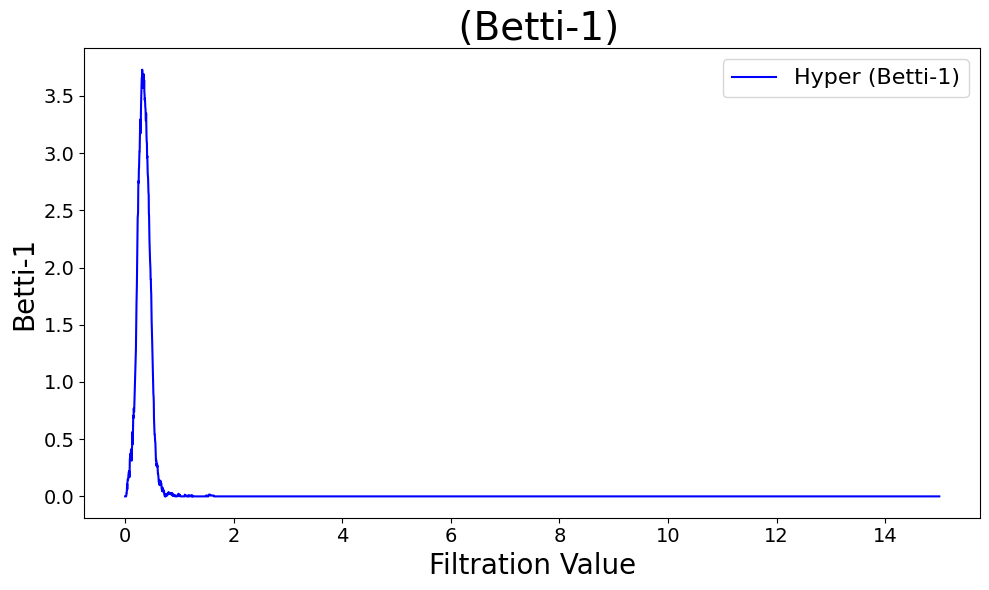

In [16]:
plot_multiple_betti_curves(
    [control_curves_norm[5]],
    labels=["Hyper"], dimension = 1,
    title=""
)

In [21]:
dim = 1
ks_results = {}
result = ks_2samp(average_hyper_norm[dim][1], average_control_norm[dim][1])
ks_results[dim] = {
    "statistic": result.statistic,
    "p_value": result.pvalue
}

# Print results
for dim, res in ks_results.items():
    print(f"Dimension {dim}: KS Statistic = {res['statistic']:.4f}, p-value = {res['p_value']:.4e}")

Dimension 1: KS Statistic = 0.1838, p-value = 5.6988e-148


In [18]:
"""iter(persistence_diagrams)"""

'iter(persistence_diagrams)'

In [19]:
"""for name, curves in betti_curves.items():
    print(f"\nDataset: {name}")
    print("Dimension | Filtration (alpha^2) | Betti value")
    print("-" * 50)
    
    for dim in sorted(curves.keys()):
        grid, curve = curves[dim]
        print(f"\n--- Dimension {dim} ---")
        for g, b in zip(grid, curve):
            print(f"{dim:<10} {g:<20.5f} {b:<10.0f}")
"""

'for name, curves in betti_curves.items():\n    print(f"\nDataset: {name}")\n    print("Dimension | Filtration (alpha^2) | Betti value")\n    print("-" * 50)\n    \n    for dim in sorted(curves.keys()):\n        grid, curve = curves[dim]\n        print(f"\n--- Dimension {dim} ---")\n        for g, b in zip(grid, curve):\n            print(f"{dim:<10} {g:<20.5f} {b:<10.0f}")\n'

In [20]:
"""grid, curve = hyper_curves_norm[0][2]

# Print all pairs
for x, y in zip(grid, curve):
    print(f"x={x:.6f}, y={y:.0f}")"""

'grid, curve = hyper_curves_norm[0][2]\n\n# Print all pairs\nfor x, y in zip(grid, curve):\n    print(f"x={x:.6f}, y={y:.0f}")'

In [32]:
def normalize_betti_curves_for_ks(betti_curves, alpha_max=15, resolution=100000):
    """
    Normalize Betti curves to create proper probability distributions for KS test.
    All curves are defined on the same domain [0, alpha_max].
    """
    normalized = {}
    
    # Create common grid
    common_grid = np.linspace(0, alpha_max, resolution)
    
    for dim, (grid, curve) in betti_curves.items():
        if len(grid) == 0:
            normalized[dim] = (common_grid, np.zeros(resolution))
            continue
        
        # Interpolate onto common grid
        f = interp1d(grid, curve, bounds_error=False, fill_value=0)
        interpolated_curve = f(common_grid)
        
        # Normalize by area (using trapezoidal rule on common grid)
        area = np.trapezoid(interpolated_curve, common_grid)
        
        if area > 0:
            normalized_curve = interpolated_curve / area
        else:
            normalized_curve = interpolated_curve
            
        normalized[dim] = (common_grid, normalized_curve)
    
    return normalized

# Replace your existing normalization code with:
norm_betti_curves = {
    name: normalize_betti_curves_for_ks(trimmed_curves, alpha_max=15)
    for name, trimmed_curves in trimmed_betti_curves.items()
}

# Get keys in insertion order
keys = list(norm_betti_curves.keys())

hyper_curves_norm = [norm_betti_curves[k] for k in keys[:5]]
control_curves_norm = [norm_betti_curves[k] for k in keys[-8:]]

# Average using the same function (it should work now since all have same grid)
average_control_norm = average_curves(control_curves_norm)
average_hyper_norm = average_curves(hyper_curves_norm)

# NOW the KS test makes sense:
dim = 1
# Both curves now have the SAME x-values (common_grid)
# The KS test compares the CDFs, which is appropriate for normalized curves
result = ks_2samp(average_hyper_norm[dim][1], average_control_norm[dim][1])
print(f"Dimension {dim}: KS Statistic = {result.statistic:.4f}, p-value = {result.pvalue:.4e}")

Dimension 1: KS Statistic = 0.1838, p-value = 5.6988e-148


In [28]:
average_control_norm

{0: (array([0.00000000e+00, 1.50015002e-03, 3.00030003e-03, ...,
         1.49969997e+01, 1.49984998e+01, 1.50000000e+01]),
  array([1.32060108e+01, 1.30676247e+01, 1.29292386e+01, ...,
         3.45447123e-03, 2.49555376e-03, 0.00000000e+00])),
 1: (array([0.00000000e+00, 1.50015002e-03, 3.00030003e-03, ...,
         1.49969997e+01, 1.49984998e+01, 1.50000000e+01]),
  array([0., 0., 0., ..., 0., 0., 0.])),
 2: (array([0.00000000e+00, 1.50015002e-03, 3.00030003e-03, ...,
         1.49969997e+01, 1.49984998e+01, 1.50000000e+01]),
  array([0., 0., 0., ..., 0., 0., 0.]))}

In [ ]:
average_hyper_norm

{0: (array([0.00000000e+00, 1.50015002e-03, 3.00030003e-03, ...,
         1.49969997e+01, 1.49984998e+01, 1.50000000e+01]),
  array([1.40998105e+01, 1.38760643e+01, 1.36523181e+01, ...,
         6.14160263e-03, 3.24493234e-03, 0.00000000e+00])),
 1: (array([0.00000000e+00, 1.50015002e-03, 3.00030003e-03, ...,
         1.49969997e+01, 1.49984998e+01, 1.50000000e+01]),
  array([0., 0., 0., ..., 0., 0., 0.])),
 2: (array([0.00000000e+00, 1.50015002e-03, 3.00030003e-03, ...,
         1.49969997e+01, 1.49984998e+01, 1.50000000e+01]),
  array([0., 0., 0., ..., 0., 0., 0.]))}

In [34]:
def save_avg_curve_dict_to_csv(filename, curve_dict):
    """
    curve_dict: {dim: (x_array, y_array)}
    Writes CSV with columns:
        k, dim0, dim1, dim2, ...
    Assumes all dims share the same k grid.
    """
    # Sort dimensions so columns appear in order
    dims = sorted(curve_dict.keys())

    # Extract x from the first dimension
    x = curve_dict[dims[0]][0]

    # Extract y arrays in dimension order
    ys = [curve_dict[d][1] for d in dims]

    # Write CSV
    with open(filename, "w", newline="") as f:
        writer = csv.writer(f)
        header = ["k"] + [f"betti_{d}" for d in dims]
        writer.writerow(header)

        for i in range(len(x)):
            row = [x[i]] + [ys[d_idx][i] for d_idx in range(len(dims))]
            writer.writerow(row)

    print(f"Saved → {filename}")


# Save both averaged curves
save_avg_curve_dict_to_csv("average_hyper_norm.csv", average_hyper_norm)
save_avg_curve_dict_to_csv("average_control_norm.csv", average_control_norm)

Saved → average_hyper_norm.csv
Saved → average_control_norm.csv
